<a href="https://colab.research.google.com/github/god7i11a/pynb/blob/main/CDC_hospital_wastewater.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hospitalization and Wastewater Data Retrieval and Visualization
#         People's CDC   http://peoplescdc.org
#               Updated 12/27/2023 @7:35 PM  by Les Schaffer

## Setup: be sure to run this first

In [18]:
import os
import re
import sys

try:
    from google.colab import userdata, output
    output.enable_custom_widget_manager()
    api_key_id = userdata.get('api_key_id')
    api_key_secret = userdata.get('api_key_secret')
    api_app_token = userdata.get('api_app_token')
    ! pip install sodapy
    ! pip install ipympl
except ModuleNotFoundError:
    sys.path.append(os.path.abspath('../'))
    from tokens import api_key_id, api_key_secret, api_app_token

get_ipython().run_line_magic('matplotlib', 'ipympl')

from sodapy import Socrata
from pandas import DataFrame, to_datetime, Series, concat
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import seaborn as sbrn

# set up Socrata clients for data queries
# hospital data by facility and by state
URL = 'healthdata.gov'
hclient = Socrata(URL, api_app_token,  username=api_key_id,   password=api_key_secret, timeout=20 )

# wastewater data by facility
URL = 'data.cdc.gov'
wclient = Socrata(URL, api_app_token,  username=api_key_id,   password=api_key_secret, timeout=20 )

In [20]:
# some  functions for later use
# x='CDC_BIOBOT_ny_505_Treatment plant_raw wastewater'
regex = re.compile('_[a-z][a-z]_(\d+)_')

def get_id(row):
  x=row.key_plot_id
  y = regex.search(x)
  shortened, theID = x[0:y.end()-1], int(y.group(1))
  print(shortened, theID)
  print(x.sample_location_specify, type(x.sample_location_specify))
  byteme
  return Series([shortened, theID])

def get_col_order(df, key_column):
    col_order = df[key_column].unique().tolist()
    col_order.sort()
    return col_order

def update_wwtp_id(df):
    df['wwtp_id'] = df.apply(get_id)
    return df

def format_axis(ax=None):
    _num2date = mdates.num2date

    def formatter(x, y):
        the_date = _num2date(x).date().isoformat()
        return f'x={the_date}, y={y:.4g}'

    if ax is None:
        ax = plt.gca()
    ax.format_coord = formatter


# Hospitalization -- by facility

## metadata

In [ ]:
RSRC ='anag-cw7u'
metadata = hclient.get_metadata(RSRC)
print([x['name'] for x in metadata['columns']])
print(metadata.keys())
print(metadata['rowsUpdatedBy'])
print(metadata['owner'])
metadata['metadata']
metadata['columns']

meta_amount = [x for x in metadata['columns'] if x['name'] == 'inpatient_beds_used_covid_7_day_avg']
meta_amount

## get the data

In [16]:
RSRC ='anag-cw7u'
# Use the 'where' argument to filter the data before downloading it
results = hclient.get(RSRC, where=u"collection_week >= '2023-12-02T00:00:00.000'", limit=100000)   # AND hospital_subtype = 'Children's Hospitals'")
results=DataFrame.from_records(results)
print("Number of results downloaded: {}".format(len(results)))

results['collection_week'] = to_datetime(results['collection_week'])
print(results['collection_week'].sort_values().unique())

Number of results downloaded: 9639
['2023-12-03T00:00:00.000000000' '2023-12-10T00:00:00.000000000']


## make tables and plots
### Children's hospitals: covid bed fraction > 20%

Number of times facilities reporting = 12263
Number of times facilities reporting -999999 --> 2 = 3361


,collection_week,hospital_name,inpatient_beds_7_day_avg,total_pediatric_patients_hospitalized_confirmed_and_suspected_covid_7_day_avg,all_pediatric_inpatient_beds_7_day_avg,percent
8522,2022-01-02T00:00:00.000,ST CHRISTOPHER'S HOSPITAL FOR CHILDREN,65.3,85.1,36.7,231.880109
2300,2020-10-04T00:00:00.000,LARABIDA CHILDRENS HOSPITAL I,NaN,30.0,29.0,103.448276
8630,2022-01-09T00:00:00.000,ST CHRISTOPHER'S HOSPITAL FOR CHILDREN,56.3,59.3,58.0,102.241379
12065,2022-09-25T00:00:00.000,SHRINERS HOSPITALS FOR CHILDREN,2.0,2.0,2.0,100.000000
8903,2022-01-30T00:00:00.000,SHRINERS HOSPITAL FOR CHILDREN - PORTLAND,12.0,2.0,2.0,100.000000
...,...,...,...,...,...,...
10549,2022-06-05T00:00:00.000,SHRINERS HOSPITALS FOR CHILDREN,48.0,2.0,10.0,20.000000
8981,2022-02-06T00:00:00.000,SHRINERS HOSPITALS FOR CHILDREN,48.0,2.0,10.0,20.000000
10441,2022-05-29T00:00:00.000,SHRINERS HOSPITALS FOR CHILDREN,48.0,2.0,10.0,20.000000
10386,2022-05-22T00:00:00.000,SHRINERS HOSPITALS FOR CHILDREN,48.0,2.0,10.0,20.000000


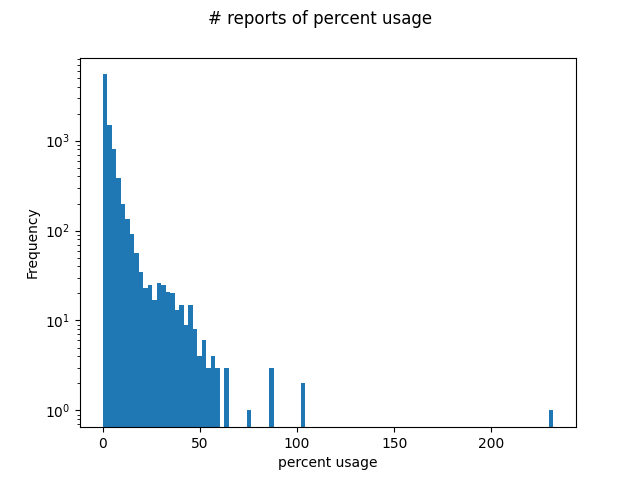

In [ ]:
query = """
SELECT
collection_week,
hospital_name,
all_pediatric_inpatient_beds_7_day_avg,
total_pediatric_patients_hospitalized_confirmed_and_suspected_covid_7_day_avg,
inpatient_beds_7_day_avg
WHERE
collection_week>'2020-03-02T00:00:00.000'
AND hospital_subtype = "Childrens Hospitals"
ORDER BY
collection_week
LIMIT
40000
"""
RSRC ='anag-cw7u'
results = hclient.get(RSRC, query=query)
res=DataFrame.from_records(results)
res=res.replace('-999999.0', '2.0')
res['total_pediatric_patients_hospitalized_confirmed_and_suspected_covid_7_day_avg'] = res['total_pediatric_patients_hospitalized_confirmed_and_suspected_covid_7_day_avg'].astype(float)
res['all_pediatric_inpatient_beds_7_day_avg']=res['all_pediatric_inpatient_beds_7_day_avg'].astype(float)
res['inpatient_beds_7_day_avg'] = res['inpatient_beds_7_day_avg'].astype(float)
res['percent'] = 100*res['total_pediatric_patients_hospitalized_confirmed_and_suspected_covid_7_day_avg']/res['all_pediatric_inpatient_beds_7_day_avg']
# cases where all_pediatric_inpatient_beds_7_day_avg is reported as 0!!!! then use inpatient_beds_7_day_avg
use_inpatient_beds = res['all_pediatric_inpatient_beds_7_day_avg']==0.0
res.loc[use_inpatient_beds, 'percent'] = 100*res[use_inpatient_beds]['total_pediatric_patients_hospitalized_confirmed_and_suspected_covid_7_day_avg']/res[use_inpatient_beds]['inpatient_beds_7_day_avg']

num = res.loc[:,'percent'].count()
print(f'Number of times facilities reporting = {num}')
hidden = res['total_pediatric_patients_hospitalized_confirmed_and_suspected_covid_7_day_avg']==2.0
num = res.loc[hidden,'percent'].count()
print(f'Number of times facilities reporting -999999 --> 2 = {num}')
plt.figure()
res.loc[~hidden, 'percent'].plot(kind='hist', bins=100, logy=True)
plt.gcf().suptitle('# reports of percent usage')
plt.gca().set_xlabel('percent usage')
res[res['percent']>=20].sort_values('percent', ascending=False)

### lets look at average usage over the entire pandemic > 5% !!!

In [ ]:
df=res.groupby(['hospital_name',])['percent'].mean()
df[df>=5.]

hospital_name
AKRON CHILDREN'S HOSPITAL                                            31.882658
ARKANSAS CHILDREN'S NORTHWEST, INC                                    9.289257
CHILDREN'S HEALTHCARE OF ATLANTA AT EGLESTON                          7.329516
CHILDREN'S HEALTHCARE OF ATLANTA AT SCOTTISH RITE                     8.328417
CHILDREN'S HOSPITAL OF SAN ANTONIO                                    6.049926
CHILDRENS MEDICAL CENTER PLANO                                        7.177250
CHILDRENS MEDICAL CTR OF DALLAS                                       5.912478
CONNECTICUT CHILDRENS MEDICAL CENTER                                 11.406597
Childrens Recovery Center of Oklahoma (FKA Oklahoma Youth Center)     5.893142
DAYTON CHILDRENS HOSPITAL                                             7.699770
EL PASO CHILDREN'S HOSPITAL                                           6.481011
MARY BRIDGE CHILDREN'S HOSPITAL                                       6.130216
MEMORIAL CARE MILLER CHILDREN'S &  WOM

### Pediatric admission, nationwide

,collection_week,previous_day_admission_pediatric_covid_confirmed_7_day_sum
67,2020-04-05,0
1137,2020-07-05,0
1170,2020-07-12,0
1173,2020-07-12,0
1174,2020-07-12,0
...,...,...
17798,2023-12-10,2
17799,2023-12-10,4
17800,2023-12-10,12
17801,2023-12-10,10


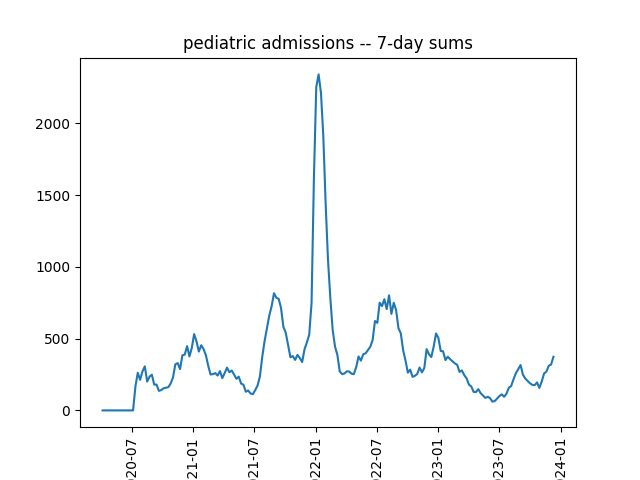

In [ ]:
query = """
SELECT
previous_day_admission_pediatric_covid_confirmed_7_day_sum,
collection_week
WHERE
collection_week>'2020-01-03T00:00:00.000' AND hospital_subtype = "Childrens Hospitals"
ORDER BY
collection_week ASC
LIMIT
30000
"""
RSRC ='anag-cw7u'
results = hclient.get(RSRC, query=query)
res=DataFrame.from_records(results)
res=res.replace('-999999', '2')
res['collection_week'] = to_datetime(res['collection_week'])
res=res[res['previous_day_admission_pediatric_covid_confirmed_7_day_sum'].notna()]
res['previous_day_admission_pediatric_covid_confirmed_7_day_sum']=res['previous_day_admission_pediatric_covid_confirmed_7_day_sum'].astype(int)
df=res.groupby('collection_week').sum()
plt.figure()
plt.plot(df['previous_day_admission_pediatric_covid_confirmed_7_day_sum'])
plt.tick_params('x', rotation=90)
plt.title('pediatric admissions -- 7-day sums')
res

## Adults

In [ ]:
query = """
SELECT
previous_day_admission_adult_covid_confirmed_7_day_sum,
total_adult_patients_hospitalized_confirmed_covid_7_day_avg,
total_adult_patients_hospitalized_confirmed_covid_7_day_sum,
collection_week
WHERE
collection_week>'2020-01-03T00:00:00.000' AND hospital_subtype != "Childrens Hospitals"
ORDER BY
collection_week ASC
LIMIT
1000000
"""
RSRC ='anag-cw7u'
results = hclient.get(RSRC, query=query)
ares=DataFrame.from_records(results)
ares=ares.replace('-999999', '2')
ares=ares.replace('-999999.0', '2.0')
ares['collection_week'] = to_datetime(ares['collection_week'])

ares=ares[ares['previous_day_admission_adult_covid_confirmed_7_day_sum'].notna()]
ares['previous_day_admission_adult_covid_confirmed_7_day_sum']=ares['previous_day_admission_adult_covid_confirmed_7_day_sum'].astype(int)

ares=ares[ares['total_adult_patients_hospitalized_confirmed_covid_7_day_avg'].notna()]
ares['total_adult_patients_hospitalized_confirmed_covid_7_day_avg']=ares['total_adult_patients_hospitalized_confirmed_covid_7_day_avg'].astype(float)

ares=ares[ares['total_adult_patients_hospitalized_confirmed_covid_7_day_sum'].notna()]
ares['total_adult_patients_hospitalized_confirmed_covid_7_day_sum']=ares['total_adult_patients_hospitalized_confirmed_covid_7_day_sum'].astype(float)
ares

,collection_week,total_adult_patients_hospitalized_confirmed_covid_7_day_avg,total_adult_patients_hospitalized_confirmed_covid_7_day_sum,previous_day_admission_adult_covid_confirmed_7_day_sum
866,2020-03-22,0.0,0.0,0
2332,2020-03-29,0.0,0.0,0
4356,2020-04-05,2.0,2.0,0
4380,2020-04-05,0.0,0.0,0
4405,2020-04-05,9.5,19.0,2
...,...,...,...,...
936112,2023-12-10,0.0,0.0,0
936113,2023-12-10,13.3,53.0,2
936114,2023-12-10,22.7,159.0,18
936115,2023-12-10,2.0,5.0,2


Text(0.5, 1.0, 'adult hospitalized -- 7-day ave')

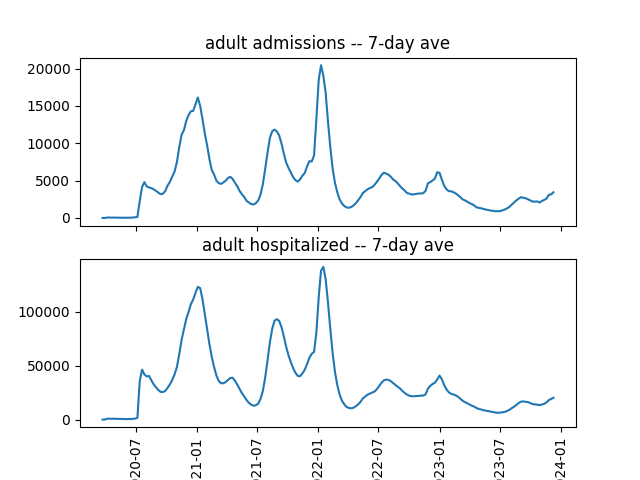

In [ ]:
df=ares.groupby('collection_week').sum()
fig, (ax1,ax2) = plt.subplots(2,1, sharex=True)
ax1.plot(df['previous_day_admission_adult_covid_confirmed_7_day_sum']/7)
ax1.tick_params('x', rotation=90)
ax1.set_title('adult admissions -- 7-day ave')

ax2.plot(df['total_adult_patients_hospitalized_confirmed_covid_7_day_avg'])
ax2.tick_params('x', rotation=90)
ax2.set_title('adult hospitalized -- 7-day ave')

# by state and nation, adult
## metadata first, only if needed

In [ ]:
RSRC ='g62h-syeh'
metadata = hclient.get_metadata(RSRC)

# print([x['name'] for x in metadata['columns']])
print(metadata.keys())
print(metadata['rowsUpdatedBy'])
print(metadata['owner'])
metadata['metadata']
metadata['columns']

## get the data

In [ ]:
RSRC ='g62h-syeh'
query = """
SELECT
hospital_onset_covid,
deaths_covid,
previous_day_admission_adult_covid_confirmed,
percent_of_inpatients_with_covid,
state,
date
WHERE
date>'2020-01-03T00:00:00.000'
ORDER BY
date ASC
LIMIT
100000
"""
colL = ('hospital_onset_covid', 'deaths_covid', 'previous_day_admission_adult_covid_confirmed', 'percent_of_inpatients_with_covid')
results = hclient.get(RSRC, query=query)
hsres=DataFrame.from_records(results)
hsres.fillna(0,inplace=True)
hsres['date'] = to_datetime(hsres['date'])
for colN in colL[:-1]:
    hsres[colN] = hsres[colN].astype(int)

hsres[colL[-1]] = hsres[colL[-1]].astype(float)
print(hsres.dtypes)
print(hsres)
hs_col_order = hsres['state'].unique().tolist()
hs_col_order.sort()

state                                                   object
date                                            datetime64[ns]
hospital_onset_covid                                     int64
deaths_covid                                             int64
percent_of_inpatients_with_covid                       float64
previous_day_admission_adult_covid_confirmed             int64
dtype: object
      state       date  hospital_onset_covid  deaths_covid  \
0        LA 2020-01-04                     0             0   
1        NC 2020-01-04                     0             0   
2        AL 2020-01-04                     0             0   
3        NV 2020-01-04                    33            29   
4        IN 2020-01-04                     0             0   
...     ...        ...                   ...           ...   
74874    NE 2023-12-23                     0             0   
74875    CT 2023-12-23                     0             0   
74876    KS 2023-12-23                     2      

## Visualize the data sets
### needs 7-day rolling averages
### needs better handling of labels (shorten the column names)
### needs ScatterMapBox maps for by_facility

### Nationwide

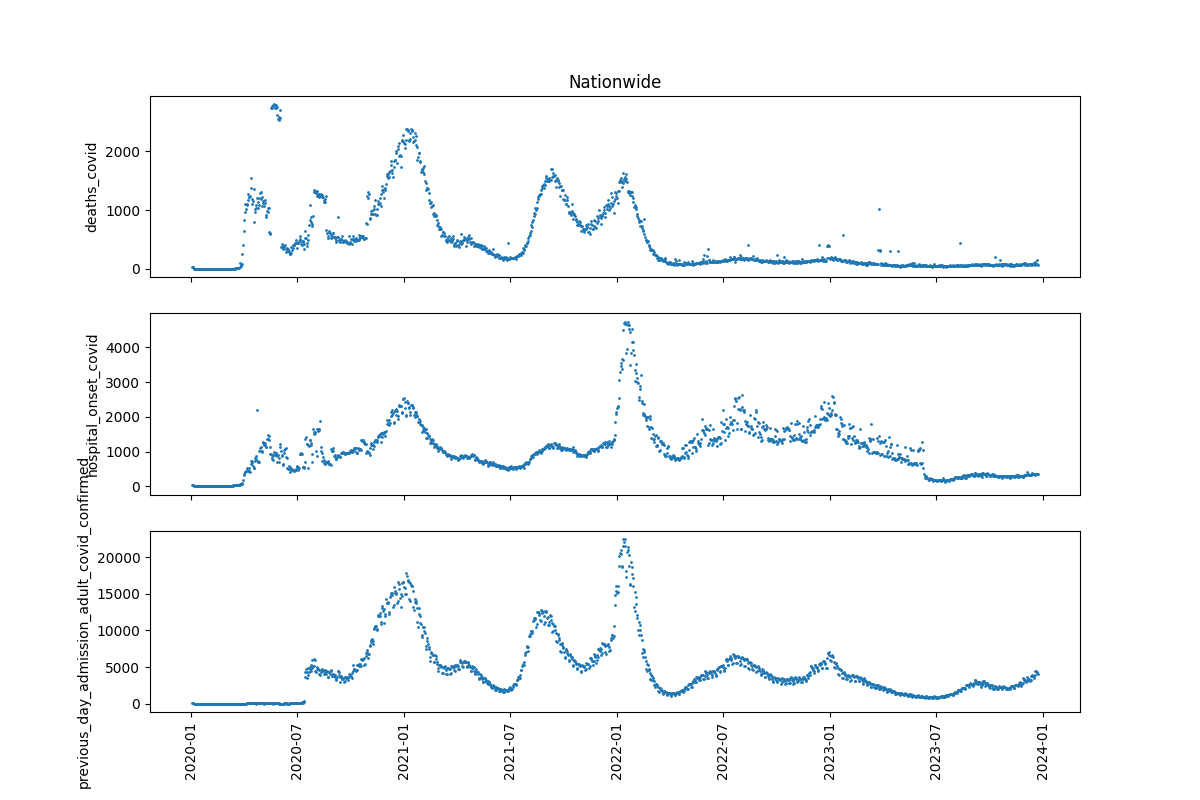

In [ ]:
fig,axL = plt.subplots(3,1, sharex=True, figsize=(12,8))
axL[0].set_title('Nationwide')
for stat, ax in zip( ('deaths_covid','hospital_onset_covid',  'previous_day_admission_adult_covid_confirmed'), axL):
    national = hsres.groupby('date')[stat].sum()
    ax.plot_date(national.index,national,ms=1)
    ax.tick_params('x', rotation=90)
    ax.set_ylabel(stat)
    format_axis(ax)

### hospital_onset_covid

In [ ]:
graph1 = sbrn.FacetGrid(hsres, col='state', col_order=hs_col_order, sharex=True, sharey=False, col_wrap=8)
graph1.map(plt.plot_date, 'date', 'hospital_onset_covid', ms=1)
graph1.tick_params('x', rotation=90)
graph1.savefig('hospital_onset_covid.png')

### deaths_covid

In [ ]:
graph2 = sbrn.FacetGrid(hsres, col='state', col_order=hs_col_order, sharex=True, sharey=False, col_wrap=8)
graph2.map(plt.plot_date, 'date', 'deaths_covid', ms=1)
graph2.tick_params('x', rotation=90)
graph2.savefig('deaths_covid.png')

### previous_day_admission_adult_covid_confirmed

In [ ]:
graph3 = sbrn.FacetGrid(hsres, col='state', col_order=hs_col_order, sharex=True, sharey=False, col_wrap=8)
graph3.map(plt.plot_date, 'date', 'previous_day_admission_adult_covid_confirmed', ms=1)
graph3.tick_params('x', rotation=90)
graph3.savefig('previous_day_admission_adult_covid_confirmed.png')

### percent_of_inpatients_with_covid

In [ ]:
graph4 = sbrn.FacetGrid(hsres, col='state', col_order=hs_col_order, sharex=True, sharey=False, col_wrap=8)
graph4.map(plt.plot_date, 'date', 'percent_of_inpatients_with_covid', ms=1)
graph4.tick_params('x', rotation=90)
graph4.savefig('percent_of_inpatients_with_covid.png')

## data summary over pandemic, by state

In [ ]:
dataD = {}
totalD = {'state':'TOTAL/AVE'}
for colN in colL[:-1]:
    dataD[colN]=hsres.groupby(['state', ])[colN].sum()
    totalD[colN] = hsres[colN].sum()

dataD[colL[-1]] = hsres.groupby(['state', ])[colL[-1]].mean()
dataD['max percentage'] = hsres.groupby(['state', ])[colL[-1]].max()

totalD[colL[-1]] = hsres[colL[-1]].mean()
totalD['max percentage'] = dataD['max percentage'].mean()
df1=DataFrame(dataD)
df2=DataFrame(totalD, index=['last'])
df2=df2.set_index('state')
df = concat([df1,df2])
df

,hospital_onset_covid,deaths_covid,previous_day_admission_adult_covid_confirmed,percent_of_inpatients_with_covid,max percentage
state,,,,,
AK,2808,1146,9634,0.053783,0.220339
AL,19538,12916,125453,0.073679,0.295075
AR,9212,7091,71755,0.080111,0.385177
AS,1,0,202,0.013239,0.410959
AZ,20200,27047,163989,0.110139,1.220200
CA,91953,72156,647961,0.094044,0.536818
CO,13892,5222,101061,0.076296,1.000000
CT,18994,5785,67616,0.081106,0.501336
DC,6005,2047,15797,0.071078,0.373717


# Wastewater code
### need to handle visualization maps by-facility
### need to develop code to bring up to county and state/nation

### initialization: enter state abbreviation at prompt

In [17]:
fieldStr = 'wwtp_jurisdiction,wwtp_id,reporting_jurisdiction,sample_location,sample_location_specify,key_plot_id,county_names,county_fips,population_served'
query = f"""
SELECT
{fieldStr}
WHERE
date_end>'2023-07-01T00:00:00.000'
LIMIT
300000
"""
results = wclient.get("2ew6-ywp6", query=query)
res0=DataFrame.from_records(results)

print(res0['key_plot_id'].count())

fields = fieldStr.split(',')
wastewater_facility_database = res0[fields]
grp=wastewater_facility_database.groupby('key_plot_id').nth(0)
grp.loc[:,'population_served'] = grp['population_served'].astype(int)
grp.to_csv('wwtp_db.csv')
grp

274200


<ipython-input-17-f03f9a4558e9>:18: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  grp.loc[:,'population_served'] = grp['population_served'].astype(int)


,wwtp_jurisdiction,wwtp_id,reporting_jurisdiction,sample_location,sample_location_specify,county_names,county_fips,population_served
key_plot_id,,,,,,,,
CDC_BIOBOT_ak_1158_Treatment plant_raw wastewater,Alaska,1158,Alaska,Treatment plant,NaN,Anchorage,02020,15000
CDC_BIOBOT_ak_1172_Treatment plant_raw wastewater,Alaska,1172,Alaska,Treatment plant,NaN,Anchorage,02020,200000
CDC_BIOBOT_ak_1490_Treatment plant_raw wastewater,Alaska,1490,Alaska,Treatment plant,NaN,Juneau,02110,10000
CDC_BIOBOT_ak_1491_Treatment plant_raw wastewater,Alaska,1491,Alaska,Treatment plant,NaN,Juneau,02110,20000
CDC_BIOBOT_al_1333_Treatment plant_raw wastewater,Alabama,1333,Alabama,Treatment plant,NaN,Colbert,01033,19000
...,...,...,...,...,...,...,...,...
WWS_vt_2031_Treatment plant_primary sludge,Vermont,2031,Vermont,Treatment plant,NaN,Washington,50023,10100
WWS_vt_2108_Treatment plant_post grit removal,Vermont,2108,Vermont,Treatment plant,NaN,Chittenden,50007,16000
WWS_wa_2457_Treatment plant_552_post grit removal,Washington,2457,Washington,Treatment plant,552,Snohomish,53061,10150


## by facility. can get all facilities in a state by inputting two letter state abbrev or particular facility by state+wwtp_id+sample_location_specify if existing

In [ ]:
wstate = input('enter state abbreviation for displaying wastewater results: ')

## pcr_conc_smoothed

In [ ]:
RSRC ='g653-rqe2'

query = f"""
SELECT
*
WHERE
date>='2020-01-03T00:00:00.000' AND key_plot_id LIKE '%_{wstate}_%'
ORDER BY
date ASC
LIMIT
90000
"""

results = wclient.get(RSRC, query=query)
res1=DataFrame.from_records(results)
res1['pcr_conc_smoothed'] =  res1['pcr_conc_smoothed'].astype(float)
res1['date'] = to_datetime(res1['date'])
res1=update_wwtp_id(res1)
w1_col_order=get_col_order(res1, 'key_plot_id')
res1

# why negative numbers for pcr_conc_smoothed???
#     key_plot_id   date      pcr_conc_smoothed    normalization       wwtp_id
# 57          527 2021-10-15      -2.875224e+06  flow-population   NWSS_ny_527
# 58           52 2021-10-15       2.960513e+07  flow-population    NWSS_ny_52
# 59         2182 2021-10-15       5.964828e+05  flow-population  NWSS_ny_2182
# 60          426 2021-10-15       1.424451e+07  flow-population   NWSS_ny_426
# 61          515 2021-10-15      -1.071621e+07  flow-population   NWSS_ny_515
# 62          522 2021-10-15      -4.880599e+06  flow-population   NWSS_ny_522
# 63          524 2021-10-15      -6.443013e+06  flow-population   NWSS_ny_524
# 64          529 2021-10-15      -1.401466e+07  flow-population   NWSS_ny_529

In [ ]:
graph1 = sbrn.FacetGrid(res1, col='key_plot_id', col_order=w1_col_order, sharex=True, sharey=False, col_wrap=7)
graph1.map(plt.plot_date, 'date', 'pcr_conc_smoothed', ms=1)
graph1.tick_params('x', rotation=90)
graph1.savefig(f'{wstate}-wastewater-1.png')

## Percentile
### needs comparison with the pcr_conc_smoothed

### every graph should have at least one 100%. but not.
#### This metric shows whether SARS-CoV-2 virus levels at a site are currently higher or lower than past historical levels at the same site.
#### 0% means levels are the lowest they have been at the site; 100% means levels are the highest they have been at the site.
#### Public health officials watch for increasing levels of the virus in wastewater over time and use this data to help make public health decisions.

In [ ]:
query = f"""
SELECT
*
WHERE
date_end>'2020-01-01T00:00:00.000' AND key_plot_id LIKE '%_{wstate}_%'
LIMIT
100000
"""
results = wclient.get("2ew6-ywp6", query=query)
res2=DataFrame.from_records(results)
res2['percentile'] =  res2['percentile'].astype(float)
res2['wwtp_id'] =  res2['wwtp_id'].astype(int)
res2['date_end'] = to_datetime(res2['date_end'])
w2_col_order=get_col_order(res2, 'key_plot_id')
res2

In [ ]:
graph2 = sbrn.FacetGrid(res2, col='key_plot_id', col_order=w2_col_order, sharex=True, sharey=False, col_wrap=7)
graph2.map(plt.plot_date, 'date_end', 'percentile', ms=1)
graph2.tick_params('x', rotation=90)
graph2.savefig(f'{wstate}-wastewater-2.png')

### PTC_15D whatever that is, it doesn't LOOK like much. maybe i goofed here???

### quoteth the Law(d):

#### The percent change in SARS-CoV-2 RNA levels over the 15-day interval defined by 'date_start' and 'date_end'.
#### Percent change is calculated as the modeled change over the interval, based on linear regression of log-transformed SARS-CoV-2 levels.
#### SARS-CoV-2 RNA levels are wastewater concentrations that have been normalized for wastewater composition.

In [ ]:
cutoff = float(input('enter upper end cutoff:  '))
res2['ptc_15d'] =  res2['ptc_15d'].astype(float)
ptc_cropped = res2[res2['ptc_15d']<cutoff]

graph3 = sbrn.FacetGrid(ptc_cropped, col='key_plot_id', col_order=w2_col_order, sharex=True, sharey=False, col_wrap=7)
graph3.map(plt.plot_date, 'date_end', 'ptc_15d', ms=1)
graph3.tick_params('x', rotation=90)
graph3.savefig(f'{wstate}-wastewater-3.png')

plt.figure()
ptc_cropped['ptc_15d'].plot(kind='hist', bins=400, logx=False, logy=True)
plt.xlabel('% change 15 days')
plt.title(f'Histogram of weird ptc_15d wastewater metric (>{cutoff} excluded)')

In [ ]:
RSRC ='g653-rqe2'

# date>='2020-01-03T00:00:00.000' AND key_plot_id LIKE '%_{wstate}_%'
# date='2023-12-22T00:00:00.000'
query = f"""
SELECT
key_plot_id,
date,
pcr_conc_smoothed
WHERE
date>='2020-01-01T00:00:00.000'
LIMIT
700000
"""

results = wclient.get(RSRC, query=query)
res3=DataFrame.from_records(results)
res3['pcr_conc_smoothed'] =  res3['pcr_conc_smoothed'].astype(float)
res3['date'] = to_datetime(res3['date'])
res3=res3[res3['pcr_conc_smoothed'].notna()]
res3

In [ ]:

x=res3.groupby('date')['pcr_conc_smoothed'].count()
fig, ax = plt.subplots(1,1, figsize=(10,8))
ax.plot_date(x.index, x, ms=1)
ax.set_ylabel('# stations reporting')
format_axis(ax)
ax.tick_params('x', rotation=90)
fig.suptitle('Number wastewater stations reporting')
plt.savefig('num_waste_stations.png')
# plt.show()

### this didnt work with the key replacement. for example, az_1212 has additional and different info and hence keys

In [ ]:
full = res3.join(grp.set_index('key_plot_id'), on='key_plot_id')
full.sort_values('date')

In [ ]:
full.dtypes
def national_pop_averaged_conc(x):
  print(x)
  byteme

In [ ]:
wgrp = full.groupby(['date','key_plot_id']).apply(national_pop_averaged_conc)

In [ ]:
tot_pop=grp['population_served'].sum()
tot_pop